# DPO

## Setup

In [1]:
from math import nan, isnan, inf, isfinite

import abc
import collections
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.stats as st
import shutil
import sys

HOME = os.path.expanduser('~')

!{sys.executable} -m pip install slurmqueen -q # pypi.org/project/slurmqueen

import slurmqueen
from slurmqueen.experiment import Command
from slurmqueen.slurm_experiment import SlurmExperiment

def getRunScript(slurmMemCap, strictFlag):
    script = [
        '',
        f'#SBATCH --mem={slurmMemCap}g',
        f'#SBATCH --mail-type=all'
    ]
    script += [
        '',
        '#SBATCH --exclusive',
        '#SBATCH --constraint=ivybridge'
    ] if strictFlag else []
    script += [
        '',
        'export XALT_EXECUTABLE_TRACKING=no',
        'ml load GCC/10.3.0 Python/3.9.5'
    ]
    return '\n'.join(script)

def getFilePaths(dirPath, fileNameEnds=set(), excludedFileNameEnds=set()):
    assert isinstance(fileNameEnds, set)
    assert isinstance(excludedFileNameEnds, set)
    dirPath = dirPath.rstrip('/')
    filePaths = []
    for (subdirPath, _, fileNames) in os.walk(os.path.expanduser(dirPath)):
        for fileName in fileNames:
            if not fileNameEnds or any(
                [fileName.endswith(fileNameEnd) for fileNameEnd in fileNameEnds]
            ):
                if all([not fileName.endswith(suffix) for suffix in excludedFileNameEnds]):
                    filePath = os.path.join(subdirPath, fileName)
                    filePaths.append(filePath)
    return sorted(filePaths)

In [2]:
DEPENDENCIES = [ # these files will be copied to NOTS (/scratch/) by SlurmQueen
    'dpmc.py',
    'wrapper.py',
    'postprocessor.py'
]

class Exp(SlurmExperiment, metaclass=abc.ABCMeta):
    def prepare_server(self, inst): # after copying files and before submitting jobs
        files = [inst.remote_experiment_path(f) for f in DEPENDENCIES]
        cmds = [f'chmod +x {" ".join(files)}']
        for relPath in ['bin', 'benchmarks']:
            projectPath = f'/projects/vardi/vhp1/{relPath}'
            scratchPath = inst.remote_experiment_path(relPath)
            cmds.append(f'mkdir -p {os.path.dirname(scratchPath)}')
            cmds.append(f'ln -sf {projectPath} {scratchPath}')
        cmd = ' && '.join(cmds)
        inst.server.execute(cmd)

    def getInst(self):
        netid = 'vhp1'
        return Inst(
            self,
            slurmqueen.ExperimentConfig(
                server=slurmqueen.SlurmServer('nots.rice.edu', netid, f'{HOME}/.ssh/id_rsa'),
                partition='scavenge',
                local_directory=os.getcwd(),
                remote_directory=f'/scratch/{netid}'
            )
        )

    @abc.abstractmethod
    def getWrapperDict(self, benchmarkPath):
        pass

    def getCmd(self, benchmarkPath):
        kwargs = {'cf': benchmarkPath, 'runner': 1}
        return Command(
            'python3',
            'wrapper.py',
            **kwargs,
            **self.getWrapperDict(benchmarkPath),
        ) | Command('python3', 'postprocessor.py')

    def getCmds(self):
        cmds = []
        filePaths = getFilePaths(self.benchmarksPath)
        for i in range(len(filePaths)):
            if not self.actualTasks or i in self.actualTasks:
                cmds.append(self.getCmd(filePaths[i]))
        return cmds

def getIntDigits(num): # SlurmQueen
    return len(str(num))

def copyFile(oldPath, newPath):
    if os.path.exists(newPath):
        raise Exception(f'Existing file: {newPath}')
    shutil.copyfile(oldPath, newPath)

In [3]:
def justifyInt(num, digits):
    assert isinstance(num, int)
    return str(num).rjust(digits, '0')

class Inst(slurmqueen.slurm_experiment.SlurmInstance):
    def getTable(self, q):
        df = self.query(q)
        return df.rename(
            columns={
                col: f'{col}{self._exp.suffix}' for col in df.head() if col not in {'file', 'cf', 'base'}
            }
        )

    def runExp(self):
        p = self._exp.id
        if os.path.exists(p):
            answer = input(f'Delete existing local file ({p}) [Y/N]: ')
            if answer.upper() == 'Y':
                shutil.rmtree(p)
            else:
                print(f'Skipped experiment ({p})')
                return
        self.run(len(self._exp.getCmds()), f'0:{self._exp.slurmTimeCap}')

    def checkData(self, allSatFlag=True):
        def checkFile(filePath):
            if os.path.isfile(filePath):
                return True
            else:
                print(f'Missing file:\t{filePath}')
                return False

        benchmarkPaths = getFilePaths(self._exp.benchmarksPath)
        for i in range(len(benchmarkPaths)):
            for ext in ['in', 'log', 'out']:
                filePath = os.path.join(
                    self._exp.id,
                    f'{justifyInt(i, getIntDigits(len(benchmarkPaths)))}.{ext}'
                )
                if checkFile(filePath):
                    if not os.path.getsize(filePath):
                        print(f'Empty file:\t{filePath}')
                    elif allSatFlag and os.path.basename(benchmarkPaths[i]) not in open(filePath).readline():
                        print(f'Wrong cf:\t{filePath}')

## Experiments

In [4]:
TIME = 1000 # paper
RUNNER_TIME = 1010 # runsolver
SLURM_TIME = 1020

MEM = 25 # paper
RUNNER_MEM = 26 # runsolver
SLURM_MEM = 28

### MaxHS

In [5]:
class MaxhsExp(Exp):
    def __init__(
        self,
        suffix,
        benchmarksPath,
        dataPath,
        memCap,
        slurmMemCap,
        timeCap,
        slurmTimeCap,
        actualTasks=[]
    ):
        self.suffix = suffix
        self.benchmarksPath = benchmarksPath
        self.memCap = memCap
        self.timeCap = timeCap
        self.slurmTimeCap = slurmTimeCap
        self.actualTasks = actualTasks
        SlurmExperiment.__init__(
            self,
            dataPath,
            self.getCmds(),
            dependencies=DEPENDENCIES,
            setup_commands=getRunScript(slurmMemCap, strictFlag=True)
        )

    def getWrapperDict(self, benchmarkPath):
        return {
            'solver': 'maxhs',
            'memcap': self.memCap,
            'timecap': self.timeCap
        }

HS = 'HS' # MaxHS

In [6]:
CHAIN0_HS_INST = MaxhsExp(
    suffix=HS,
    benchmarksPath='benchmarks/fweight/wcnf/chain/easy',
    dataPath='data/chain/easy/maxhs',
    memCap=RUNNER_MEM,
    slurmMemCap=SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME,
).getInst()
# CHAIN0_HS_INST.runExp()
# CHAIN0_HS_INST._gather()
CHAIN0_HS_INST.checkData()

In [7]:
CHAIN1_HS_INST = MaxhsExp(
    suffix=HS,
    benchmarksPath='benchmarks/fweight/wcnf/chain/hard',
    dataPath='data/chain/hard/maxhs',
    memCap=RUNNER_MEM,
    slurmMemCap=SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
# CHAIN1_HS_INST.runExp()
# CHAIN1_HS_INST._gather()
CHAIN1_HS_INST.checkData()

### UWrMaxSAT

In [8]:
class UwrExp(Exp):
    def __init__(
        self,
        suffix,
        benchmarksPath,
        dataPath,
        memCap,
        slurmMemCap,
        timeCap,
        slurmTimeCap,
        actualTasks=[]
    ):
        self.suffix = suffix
        self.benchmarksPath = benchmarksPath
        self.memCap = memCap
        self.timeCap = timeCap
        self.slurmTimeCap = slurmTimeCap
        self.actualTasks = actualTasks
        SlurmExperiment.__init__(
            self,
            dataPath,
            self.getCmds(),
            dependencies=DEPENDENCIES,
            setup_commands=getRunScript(slurmMemCap, strictFlag=True)
        )

    def getWrapperDict(self, benchmarkPath):
        return {
            'solver': 'uwr',
            'memcap': self.memCap,
            'timecap': self.timeCap,
            'vs': 0
        }

WR = 'WR' # UWrMaxSAT

In [9]:
CHAIN0_WR_INST = UwrExp(
    suffix=WR,
    benchmarksPath='benchmarks/iweight/wcnf/chain/easy',
    dataPath='data/chain/easy/uwr',
    memCap=RUNNER_MEM,
    slurmMemCap=SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME,
).getInst()
# CHAIN0_WR_INST.runExp()
# CHAIN0_WR_INST._gather()
CHAIN0_WR_INST.checkData()

In [10]:
CHAIN1_WR_INST = UwrExp(
    suffix=WR,
    benchmarksPath='benchmarks/iweight/wcnf/chain/hard',
    dataPath='data/chain/hard/uwr',
    memCap=RUNNER_MEM,
    slurmMemCap=SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME,
).getInst()
# CHAIN1_WR_INST.runExp()
# CHAIN1_WR_INST._gather()
# CHAIN1_WR_INST.renameFiles()
CHAIN1_WR_INST.checkData()

### DPMC

In [11]:
class DpmcExp(Exp):
    def __init__(
        self,
        ep,
        sif,
        suffix,
        benchmarksPath,
        dataPath,
        memCap,
        slurmMemCap,
        timeCap,
        slurmTimeCap,
        actualTasks=[]
    ):
        self.ep = ep
        self.sif = sif
        self.suffix = suffix
        self.benchmarksPath = benchmarksPath
        self.memCap = memCap
        self.timeCap = timeCap
        self.slurmTimeCap = slurmTimeCap
        self.actualTasks = actualTasks
        SlurmExperiment.__init__(
            self,
            dataPath,
            self.getCmds(),
            dependencies=DEPENDENCIES,
            setup_commands=getRunScript(slurmMemCap, strictFlag=True)
        )

    def getWrapperDict(self, benchmarkPath):
        return {
            'solver': 'dpmc',
            'memcap': self.memCap,
            'timecap': self.timeCap,
            'wc': 1,
            'er': 1,
            'mf': 1,
            'mv': 1,
            'sif': self.sif,
            'ep': self.ep,
        }

DSX = 'DSX' # DPMC, SAT-solver pruning, XOR-CNF native mode

#### Chain benchmarks

##### Easy

In [12]:
CHAIN0_DSX_INST = DpmcExp(
    ep=1,
    sif=0,
    suffix=DSX,
    benchmarksPath='benchmarks/fweight/xcnf/chain/easy',
    dataPath='data/chain/easy/dpmc/satprune/xor',
    memCap=RUNNER_MEM,
    slurmMemCap=SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME,
).getInst()
# CHAIN0_DSX_INST.runExp()
# CHAIN0_DSX_INST._gather()
CHAIN0_DSX_INST.checkData()

##### Hard

In [13]:
CHAIN1_DSX_INST = DpmcExp(
    ep=1,
    sif=0,
    suffix=DSX,
    benchmarksPath='benchmarks/fweight/xcnf/chain/hard',
    dataPath='data/chain/hard/dpmc/satprune/xor',
    memCap=RUNNER_MEM,
    slurmMemCap=SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
# CHAIN1_DSX_INST.runExp()
# CHAIN1_DSX_INST._gather()
CHAIN1_DSX_INST.checkData()

## Analysis

### Chain benchmarks

#### Easy

In [14]:
q = 'select file, base, logsol, sol, model, varcount, time, mem, timeout, memout from data '
q += 'where model is not null '
q += 'order by time'

CHAIN0_HS_INST.query(q)

,file,base,logsol,sol,model,varcount,time,mem,timeout,memout
0,88,chain_n140_k14,-30.373689,4.229714e-31,1011100000101100000111100101110101000011011001...,12008.0,2.25290,0.018820,0,0
1,68,chain_n130_k15,-23.875971,1.330543e-24,1010101100011101010111101001100000101010010100...,10882.0,9.75399,0.101844,0,0
2,25,chain_n110_k14,-21.377196,4.195696e-22,1000000010010001111011011111001000001011010110...,7850.0,10.79240,0.087056,0,0
3,20,chain_n100_k30,-15.833720,1.466493e-16,0110111111110101100000010011100100110011000010...,24836.0,35.35740,0.268096,0,0
4,113,chain_n150_k18,-28.760350,1.736401e-29,0100010100100001000001111011011000000000110000...,18546.0,45.22840,0.246688,0,0
...,...,...,...,...,...,...,...,...,...,...
369,310,chain_n240_k26,-49.547256,2.836247e-50,1011111111110111101111001110100101110100101110...,67057.0,218.49800,0.665260,0,0
370,371,chain_n270_k24,-58.543749,2.859243e-59,0111011010011001011110010000001001000101000010...,75423.0,219.11700,0.656068,0,0
371,97,chain_n140_k23,-28.465205,3.426060e-29,1011110100111111001100101111110001011011111000...,26762.0,219.32000,0.325504,0,0
372,245,chain_n210_k24,-43.890610,1.286441e-44,0110100000011110001000111010110101111000100000...,51911.0,549.71500,0.704396,0,0


In [15]:
q = 'select file, base, logsol, model, varcount, time, mem, timeout, memout from data '
q += 'where model is not null '
q += 'and timeout = 0 '
q += 'order by time'

CHAIN0_WR_INST.query(q)

,file,base,logsol,model,varcount,time,mem,timeout,memout
0,63,chain_n130_k10,242.0,1011011101111101111110001100110111100010011010...,4454.0,0.082187,0.000000,0,0
1,0,chain_n100_k10,183.0,1011111100101111000010000100111100101000110011...,3964.0,0.124409,0.000000,0,0
2,21,chain_n110_k10,203.0,1100100010010111000110111111111011100110111111...,4710.0,0.140769,0.004184,0,0
3,43,chain_n120_k11,221.0,0101111011110001001010011011001000110100000010...,5496.0,0.168150,0.005168,0,0
4,126,chain_n160_k10,297.0,1101011111000011010010000101111110011010101101...,6968.0,0.176608,0.005584,0,0
...,...,...,...,...,...,...,...,...,...
324,36,chain_n110_k25,200.0,0100010100011100001010111010010101011110111111...,25895.0,933.811000,0.123180,0,0
325,19,chain_n100_k29,183.0,1100001000011101000000110110001000010011111001...,25022.0,964.423000,0.132632,0,0
326,308,chain_n240_k24,440.0,1001111000001000110100100101001011111010000101...,58337.0,965.319000,0.231580,0,0
327,204,chain_n190_k25,348.0,1100011001111111110111110111000100111111100100...,50614.0,974.487000,0.190332,0,0


In [16]:
q = 'select file, base, prunetime, prunecount, logbound, applogsol, logsol, sol, treetime, time, mem from data '
q += 'where sol is not null '
q += 'order by time'

CHAIN0_DSX_INST.query(q)

,file,base,prunetime,prunecount,logbound,applogsol,logsol,sol,treetime,time,mem
0,168,chain_n180_k10,0.000,0,-61.612915,-35.848368,-35.848368,0.000000e+00,0.019907,0.230807,0.027360
1,147,chain_n170_k10,0.000,0,-61.317771,-33.167617,-33.167617,0.000000e+00,0.018591,0.232743,0.027100
2,63,chain_n130_k10,0.000,0,-48.209160,-24.830218,-24.830218,0.000000e+00,0.016250,0.233433,0.025016
3,210,chain_n200_k10,0.000,0,-68.882903,-44.549719,-44.549719,0.000000e+00,0.020566,0.243387,0.027104
4,66,chain_n130_k13,0.000,0,-46.777796,-24.830218,-24.830218,0.000000e+00,0.020750,0.244611,0.014328
...,...,...,...,...,...,...,...,...,...,...,...
517,13,chain_n100_k23,0.000,0,-36.349936,-18.219329,-18.219329,1.000000e-18,0.054407,3.172920,0.047268
518,20,chain_n100_k30,0.000,0,-38.258421,-15.833722,-15.833722,1.470000e-16,0.099399,3.248910,0.040368
519,519,chain_n390_k37,0.028,0,-147.013086,-76.876261,-76.876261,0.000000e+00,0.853773,3.250820,0.142816
520,521,chain_n390_k39,0.012,0,-143.673237,-84.033080,-84.033080,0.000000e+00,1.023050,3.501670,0.127636


#### Hard

In [17]:
q = 'select file, base, logsol, sol, time, mem, timeout, memout from data '
q += 'where sol is not null '
q += 'and timeout = 0 '
q += 'order by time'

CHAIN1_HS_INST.query(q)

,file,base,logsol,sol,time,mem,timeout,memout


In [18]:
q = 'select file, base, logsol, sol, time, mem, timeout, memout from data '
q += 'where sol is not null '
q += 'and timeout = 0 '
q += 'order by time'

CHAIN1_WR_INST.query(q)

,file,base,logsol,sol,time,mem,timeout,memout


In [19]:
q = 'select file, base, prunetime, prunecount, logbound, applogsol, logsol, sol, treetime, time, mem from data '
q += 'where sol is not null '
q += 'order by time'

CHAIN1_DSX_INST.query(q)

,file,base,prunetime,prunecount,logbound,applogsol,logsol,sol,treetime,time,mem
0,6,chain_n500_k40,0.002,0.0,-182.703924,-103.501796,-103.501796,0.0,1.45819,5.48164,0.121600
1,0,chain_n400_k40,0.000,0.0,-141.582776,-82.419740,-82.419740,0.0,1.17352,5.85414,0.116992
2,12,chain_n600_k40,0.022,0.0,-225.733558,-123.152489,-123.152489,0.0,1.80480,7.28133,0.138704
3,1,chain_n400_k50,0.252,0.0,-143.491261,-81.942619,-81.942619,0.0,2.51548,8.31360,0.218856
4,18,chain_n700_k40,0.003,0.0,-245.384251,-138.986211,-138.986211,0.0,2.14624,8.68983,0.127700
5,30,chain_n900_k40,0.005,0.0,-330.012155,-182.581687,-182.581687,0.0,2.73828,10.01090,0.155480
6,24,chain_n800_k40,0.075,0.0,-291.753734,-173.904784,-173.904784,0.0,2.44478,10.93370,0.172100
7,13,chain_n600_k50,0.134,0.0,-221.439467,-121.721125,-121.721125,0.0,3.99524,12.25520,0.179600
8,19,chain_n700_k50,0.023,0.0,-252.541070,-137.554847,-137.554847,0.0,4.71014,13.08290,0.158844
9,25,chain_n800_k50,0.048,0.0,-293.662219,-170.087814,-170.087814,0.0,5.44783,14.87720,0.161888


## Performance

### Tables

In [20]:
q = 'select base, model, mem, time from data '

CHAIN0_PERF_TABLE = CHAIN0_HS_INST.getTable(q)

CHAIN0_PERF_TABLE = CHAIN0_PERF_TABLE.merge(CHAIN0_WR_INST.getTable(q))

CHAIN0_PERF_TABLE = CHAIN0_PERF_TABLE.merge(CHAIN0_DSX_INST.getTable(q))

CHAIN0_PERF_TABLE

,base,modelHS,memHS,timeHS,modelWR,memWR,timeWR,modelDSX,memDSX,timeDSX
0,chain_n100_k10,1011110000101111110010000100111100101000000011...,0.058300,100.719,1011111100101111000010000100111100101000110011...,0.000000,0.124409,1011111100101111110010000100111100101000110011...,0.040348,1.12956
1,chain_n100_k11,1100001110001101011010100101000111111011111011...,0.065428,100.548,1110101110001101011010010101000111111011111011...,0.004528,0.191026,1110101110001101011010100101000111111011111011...,0.030532,1.33645
2,chain_n100_k12,0111010011001101110111111110010100011110100101...,0.088636,101.910,0101010001001111110100011010010000011010100001...,0.006320,0.388228,0111010011001101110111111110010100011110100101...,0.028336,1.33838
3,chain_n100_k13,0111100001111111000111000111110010101101000010...,0.095000,101.923,0111100110101111000111110111110010101101000010...,0.005404,0.220818,0111110011111111000111000111110010101101000010...,0.030624,1.16300
4,chain_n100_k14,0010000001010111110011000111110111011011011010...,0.080868,102.617,0010000101110111110011110110010111011000000000...,0.023496,6.208500,0010010001110111110110110111110110001011011010...,0.030128,1.20973
...,...,...,...,...,...,...,...,...,...,...
517,chain_n390_k35,None,1.501908,1010.250,1111110000000000001100111111100111000000000111...,0.288900,1010.030000,1111100101111010011100110000100110100111011011...,0.112528,1.65218
518,chain_n390_k36,None,1.124344,1010.280,0000101100001011001111100001010000111111111100...,0.310244,1010.040000,1111111011110010001100101111011101110011011111...,0.139988,3.00866
519,chain_n390_k37,None,0.898420,1010.280,1000010110101111010010101100000011001111111001...,0.255816,1010.030000,1111111001101000110001000101000110010001110010...,0.142816,3.25082
520,chain_n390_k38,None,1.091344,1010.280,None,0.217992,1010.040000,0000100111000000011111010000111101011010110101...,0.129720,2.61327


In [21]:
q = 'select base, model, mem, time from data '

CHAIN1_PERF_TABLE = CHAIN1_WR_INST.getTable(q)

# CHAIN1_PERF_TABLE = CHAIN1_PERF_TABLE.merge(CHAIN1_HS_INST.getTable(q))

CHAIN1_PERF_TABLE = CHAIN1_PERF_TABLE.merge(CHAIN1_DSX_INST.getTable(q))

CHAIN1_PERF_TABLE

,base,modelWR,memWR,timeWR,modelDSX,memDSX,timeDSX
0,chain_n400_k40,1110000111111000011000001111001011111100000000...,0.327236,1010.03,1111111111011101011010000010111000010011111111...,0.116992,5.85414
1,chain_n400_k50,1110000001111001000000011111111111110000101001...,0.404228,1010.04,1010111000111111011011100111100011111111011110...,0.218856,8.31360
2,chain_n400_k60,None,0.380084,1010.04,1100001100011011111011111111100010011100011001...,0.207944,22.92830
3,chain_n400_k70,None,0.534156,1010.04,1111111110111011101100111101101111111001101001...,0.271272,33.18230
4,chain_n400_k80,None,0.714688,1010.03,None,5.052920,1010.20000
5,chain_n400_k90,None,1.009716,1010.03,None,2.908264,1010.10000
6,chain_n500_k40,0001000001101010111100111100000110101011110011...,0.323588,1010.04,0101001101000011010001010111110010010101110011...,0.121600,5.48164
7,chain_n500_k50,0001111001000011111000011111111000011110000000...,0.499516,1010.04,1111010111110101001100000001111010111010111111...,0.174152,15.14830
8,chain_n500_k60,None,0.571668,1010.03,0110101111001001010111000101011110101001001111...,0.242552,24.28360
9,chain_n500_k70,None,0.659076,1010.04,0110111010000111100000000110111000010000011001...,0.265756,27.49430


In [22]:
def getTime(row, suffix): # returns nan or finite num
    t = row[f'time{suffix}']
    assert isnan(t) or 0 < t < SLURM_TIME, t
    return t

def getMem(row, suffix):
    m = row[f'mem{suffix}']
    assert isnan(m) or 0 <= m < SLURM_MEM, m
    return m

def isQualified(row, suffix, maxMem, maxTime): # allows solution underflow as model is given
    time = getTime(row, suffix)
    if isnan(time) or time > maxTime:
        return False

    mem = getMem(row, suffix)
    if isnan(mem) or mem > maxMem:
        return False

    return row[f'model{suffix}'] != None

def getQualifiedTime(row, suffix, maxMem, maxTime): # returns nan or finite num
    return getTime(row, suffix) if isQualified(row, suffix, maxMem, maxTime) else nan

def getVbsMems(table, suffixes, maxMem=MEM, maxTime=TIME): # returns list of nans and finite nums
    mems = []
    for (_, row) in table.iterrows():
        mem = inf
        for suffix in suffixes:
            mem = min(mem, getMem(row, suffix))
        if isfinite(mem):
            mems.append(mem)
    return mems

np.mean(getVbsMems(CHAIN0_PERF_TABLE, [
    'HS',
#     'WR',
#     'DSX'
]))

0.5474935555555557

#### Unique completions

In [23]:
def getUniqueCompletions(table, suffixes, maxMem=MEM, maxTime=TIME): # returns solver |-> completions
    completions = collections.Counter()
    for (_, row) in table.iterrows():
        solver = ''
        for suffix in suffixes:
            if isQualified(row, suffix, maxMem, maxTime):
                if solver:
                    solver = ''
                    break
                else:
                    solver = suffix
        if solver:
            completions[solver] += 1
    return completions

In [24]:
getUniqueCompletions(CHAIN0_PERF_TABLE, [
    HS,
    WR,
    DSX,
])

Counter({'DSX': 146})

In [25]:
getUniqueCompletions(CHAIN1_PERF_TABLE, [
#     HS,
    WR,
    DSX,
])

Counter({'DSX': 31})

#### Fastest completions

In [26]:
def getFastestCompletions(table, suffixes, maxMem=MEM, maxTime=TIME): # returns solver |-> completions
    completions = collections.Counter()
    for (_, row) in table.iterrows():
        time = inf
        solver = ''
        for suffix in suffixes:
            if isQualified(row, suffix, maxMem, maxTime):
                t = getTime(row, suffix)
                if t < time:
                    time = t
                    solver = suffix
                elif t == time:
                    solver = ''
        if solver:
            completions[solver] += 1
    return completions

In [27]:
getFastestCompletions(CHAIN0_PERF_TABLE, [
    HS,
    WR,
    DSX,
])

Counter({'WR': 22, 'DSX': 500})

In [28]:
getFastestCompletions(CHAIN1_PERF_TABLE, [
#     HS,
    WR,
    DSX,
])

Counter({'DSX': 31})

#### Total completions

In [29]:
def getTotalCompletions(table, suffixes, maxMem=MEM, maxTime=TIME): # returns int
    completions = 0
    for (_, row) in table.iterrows():
        for suffix in suffixes:
            if isQualified(row, suffix, maxMem, maxTime):
                completions += 1
                break
    return completions

In [30]:
getTotalCompletions(CHAIN0_PERF_TABLE, [
    HS,
    WR,
    DSX,
])

522

In [31]:
getTotalCompletions(CHAIN1_PERF_TABLE, [
#     HS,
    WR,
    DSX,
])

31

#### PAR-2 scores

In [32]:
def getSolverTimes(table, suffix, maxMem, maxTime): # returns list of nans and finite nums
    times = []
    for (_, row) in table.iterrows():
        times.append(getQualifiedTime(row, suffix, maxMem, maxTime))
    return times

def getPar2Scores(times, maxTime):
    return [time if isfinite(time) else maxTime * 2 for time in times]

def roundFloat(num, decimalPlaces):
    f = round(num, decimalPlaces)
    return int(f) if f.is_integer() else f

def getMeanAndConfidenceInterval(nums, decimalPlaces):
    avg = np.mean(nums)
    ends = st.norm.interval(alpha=0.95, loc=avg, scale=st.sem(nums))
    return (roundFloat(avg, decimalPlaces), [roundFloat(e, decimalPlaces) for e in ends])

def getSolverMeanPar2Scores(table, suffixes, maxMem=MEM, maxTime=TIME, decimalPlaces=1):
    mapping = {}
    for suffix in suffixes:
        scores = getPar2Scores(getSolverTimes(table, suffix, maxMem, maxTime), maxTime)
        mapping[suffix] = getMeanAndConfidenceInterval(scores, decimalPlaces)
    return mapping

In [33]:
getSolverMeanPar2Scores(CHAIN0_PERF_TABLE, [
    HS,
    WR,
    DSX,
], MEM, decimalPlaces=0)

{'HS': (671, [599, 743]), 'WR': (838, [760, 916]), 'DSX': (1, [1, 1])}

In [34]:
def getVbsTimes(table, suffixes, maxMem, maxTime): # returns list of nans and finite nums
    times = []
    for (_, row) in table.iterrows():
        time = inf
        for suffix in suffixes:
            if isQualified(row, suffix, maxMem, maxTime):
                t = getTime(row, suffix)
                if t == time:
                    raise Exception('equal times')
                elif t < time:
                    time = t
        times.append(time if isfinite(time) else nan)
    return times

def getVbsMeanPar2Scores(table, suffixTuples, maxMem=MEM, maxTime=TIME, decimalPlaces=2):
    mapping = {}
    for suffixTuple in suffixTuples:
        scores = getPar2Scores(getVbsTimes(table, suffixTuple, maxMem, maxTime), maxTime)
        mapping[suffixTuple] = getMeanAndConfidenceInterval(scores, decimalPlaces)
    return mapping

In [35]:
getVbsMeanPar2Scores(CHAIN0_PERF_TABLE, [(HS, WR), (
    HS, WR,
    DSX,
)], MEM, decimalPlaces=0)

{('HS', 'WR'): (623, [549, 697]), ('HS', 'WR', 'DSX'): (1, [1, 1])}

### Figures

In [36]:
plt.rcParams.update({
    'figure.dpi': 500,
    'font.size': 9,
    'text.usetex': True # type-1 font
})

def getFigAx(heightByWidth):
    def getFigSize(heightByWidth):
        figWidthPt = 398.33858 # SAT22 \the\textwidth
        figWidthPt *= 1.1 # still fits
        figWidthIn = figWidthPt / 72.27
        figHeightIn = heightByWidth * figWidthIn
        return (figWidthIn, figHeightIn)

    (fig, ax) = plt.subplots(figsize=getFigSize(heightByWidth))
    ax.grid(True)
    return (fig, ax)

def saveFig(fig, filePath):
    filePath = os.path.expanduser(filePath)
    os.makedirs(os.path.dirname(filePath), exist_ok=True)
    fig.savefig(filePath, bbox_inches='tight')

def plotScatter(table, xSuffix, xLabel, ySuffix, yLabel, maxMem, maxTime=TIME):
    (fig, ax) = getFigAx(1)
    xs = getSolverTimes(table, xSuffix, maxMem, maxTime)
    ys = getSolverTimes(table, ySuffix, maxMem, maxTime)
    ax.scatter(xs, ys)
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    ax.set_xlim(0, maxTime)
    ax.set_ylim(0, maxTime)
    ax.axline((0, 0), slope=1)

In [37]:
def drawCurve(ax, timeList, label, style):
    def getTimesAndCompletions(timeList): # returns (times, completions)
        timeList = sorted(timeList)
        times = timeList[:1]
        completions = [1]
        for t in timeList[1:]:
            if t == times[-1]:
                completions[-1] += 1
            else:
                times.append(t)
                completions.append(1 + completions[-1])
        return (times, completions)

    ax.plot(*getTimesAndCompletions(timeList), label=label, linestyle=style, linewidth=1)
    ax.legend()
    ax.set_xscale('log')
    ax.set_xlabel('Longest solving time (seconds)')
    ax.set_ylabel('Number of solved benchmarks')

def drawSolverCurve(ax, table, suffix, label, style, maxMem=MEM, maxTime=TIME):
    drawCurve(ax, filter(isfinite, getSolverTimes(table, suffix, maxMem, maxTime)), label, style)

def drawVbsCurve(ax, table, suffixes, label, style, maxMem=MEM, maxTime=TIME):
    drawCurve(
        ax,
        filter(isfinite, getVbsTimes(table, suffixes, maxMem, maxTime)),
        label,
        style
    )

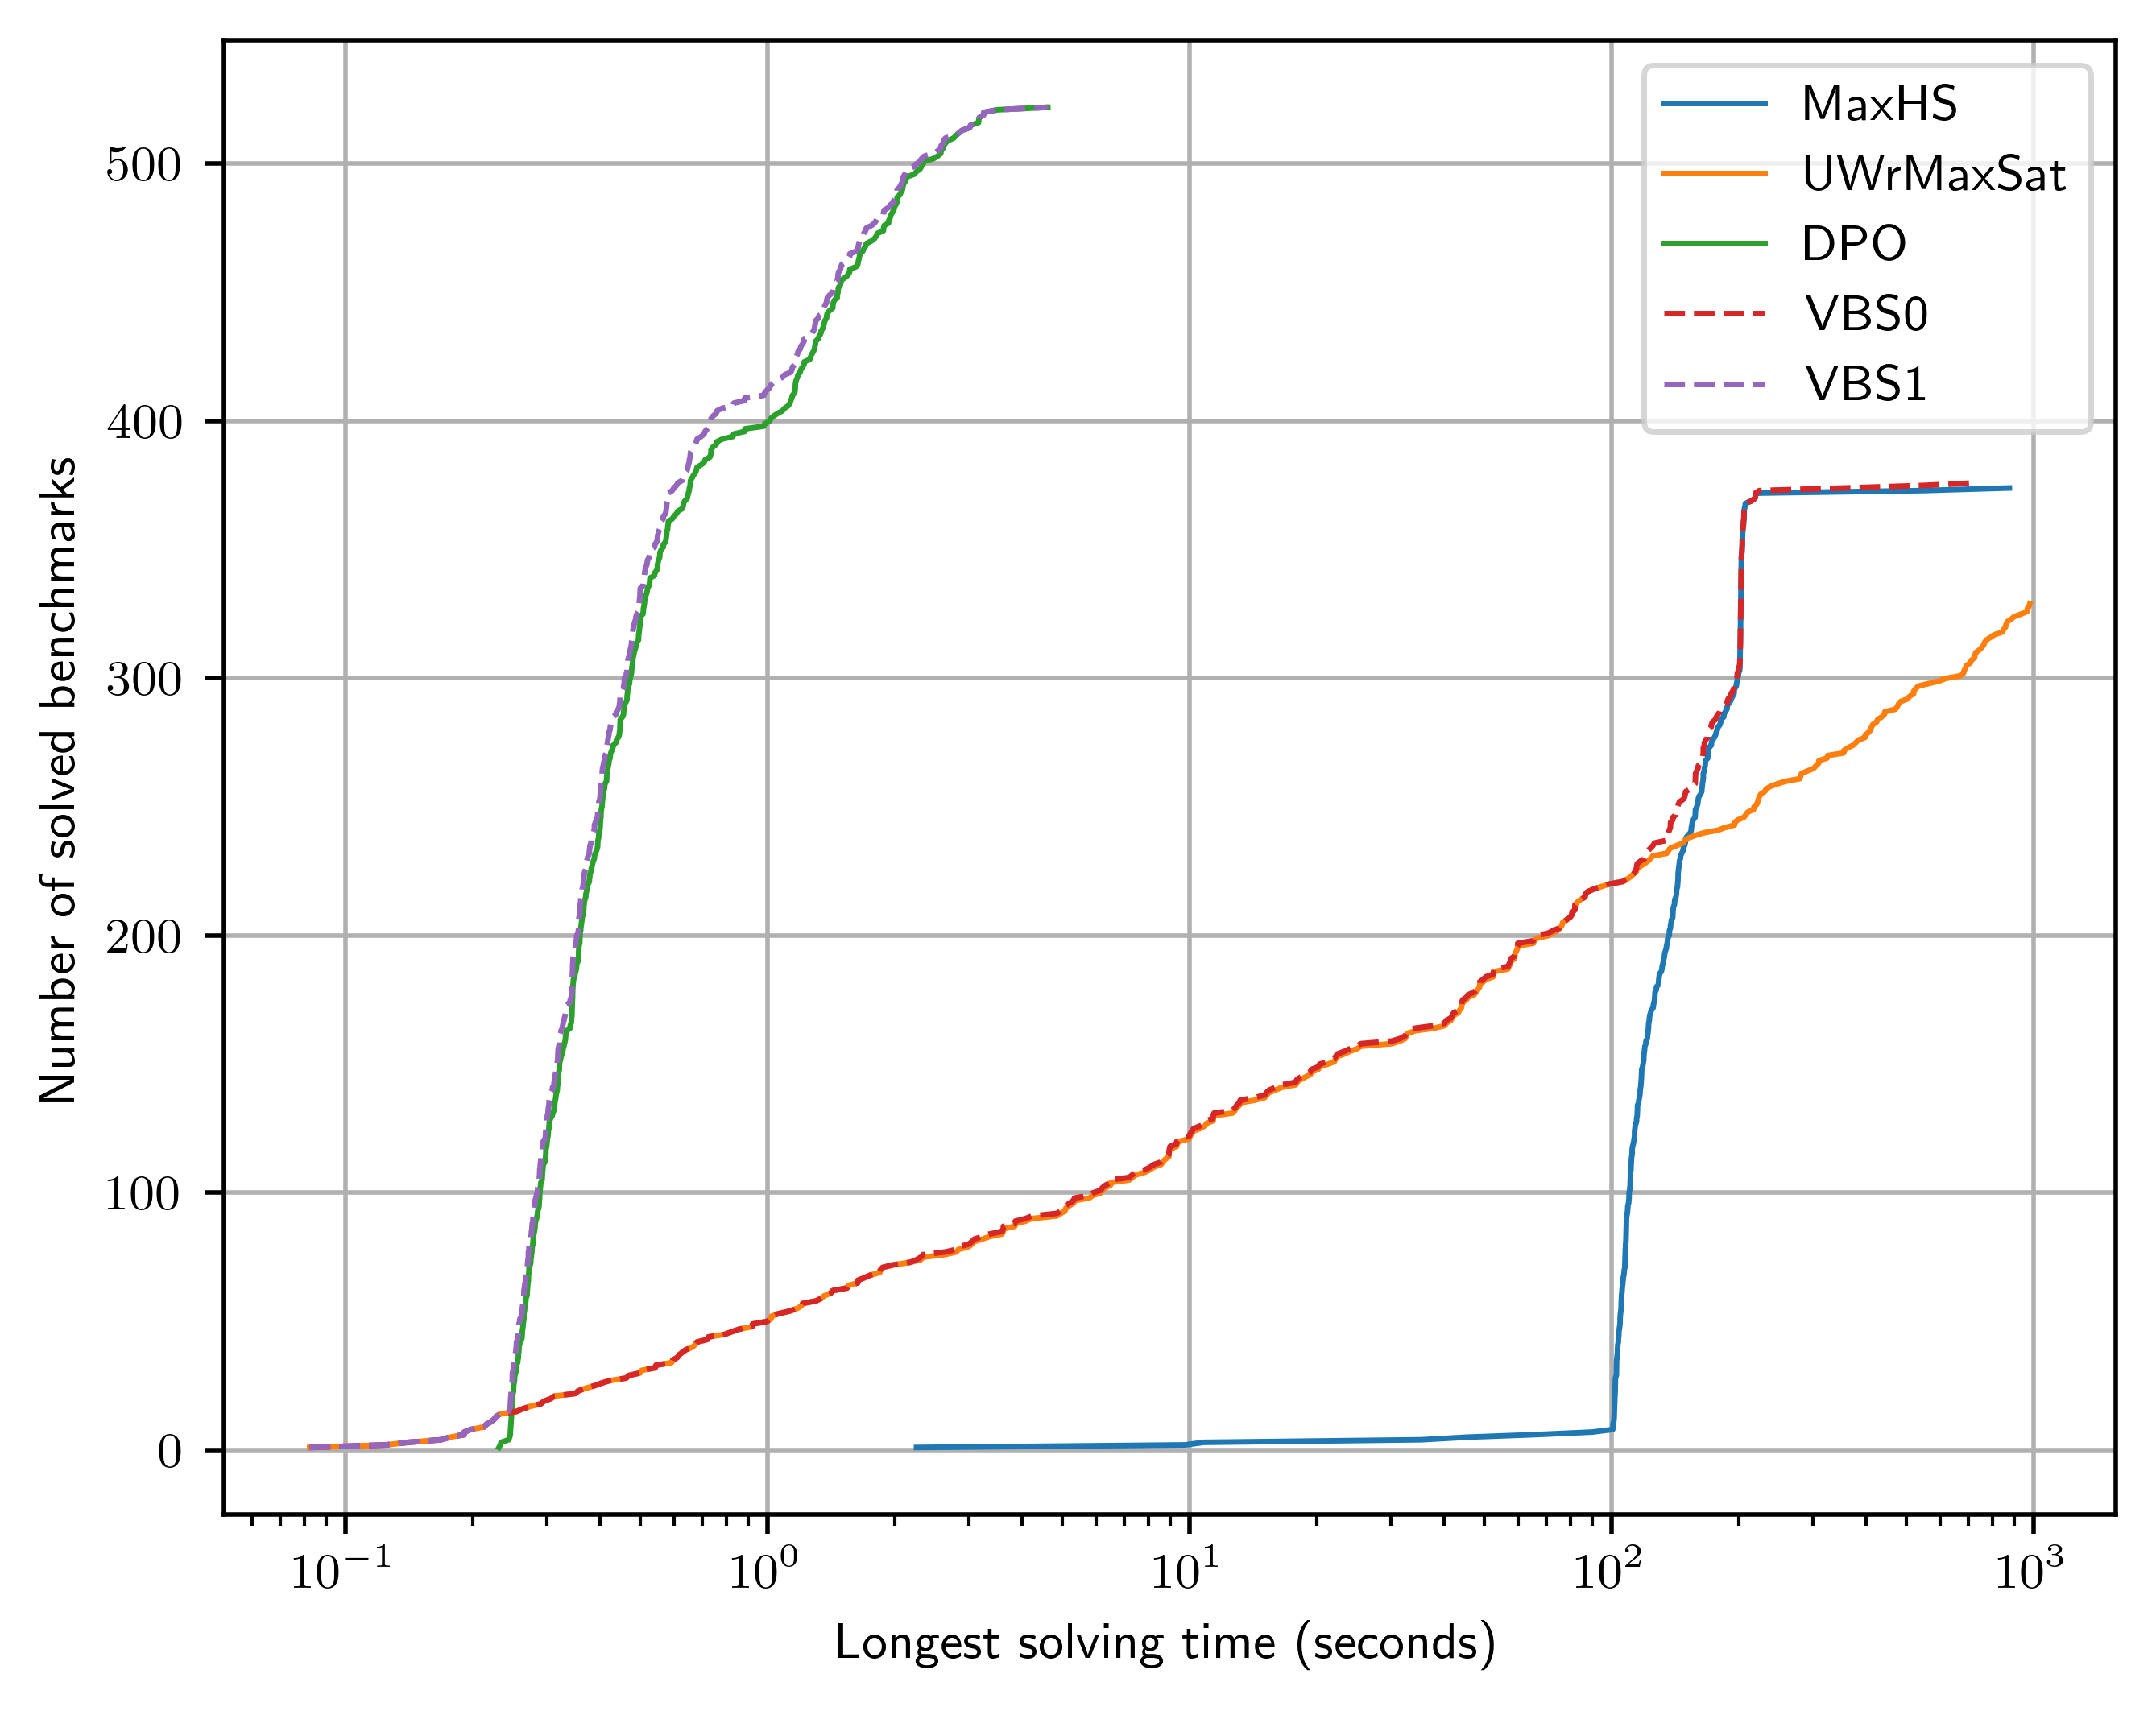

In [38]:
(fig, ax) = getFigAx(.8)

drawSolverCurve(ax, CHAIN0_PERF_TABLE, HS, 'MaxHS', '-')
drawSolverCurve(ax, CHAIN0_PERF_TABLE, WR, 'UWrMaxSat', '-')
drawSolverCurve(ax, CHAIN0_PERF_TABLE, DSX, 'DPO', '-')

drawVbsCurve(ax, CHAIN0_PERF_TABLE, [HS, WR], 'VBS0', '--')
drawVbsCurve(ax, CHAIN0_PERF_TABLE, [
    HS, WR,
    DSX,
], 'VBS1', '--')

# saveFig(fig, '~/code/sat22/figures/solvers-chain-easy.pgf')